In [1]:
# notebooks/01_eda.ipynb

"""
Exploratory Data Analysis for Waste Classification Dataset
12 Classes: battery, biological, brown-glass, cardboard, clothes, 
            green-glass, metal, paper, plastic, shoes, trash, white-glass
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Data directory
DATA_DIR = Path('../data/raw')

print(" WASTE CLASSIFICATION - EXPLORATORY DATA ANALYSIS")
print("="*70)
print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Dataset exists: {DATA_DIR.exists()}")

 WASTE CLASSIFICATION - EXPLORATORY DATA ANALYSIS
Data directory: /Users/caoduong22102004gmail.com/waste-classification-vn/notebooks/../data/raw
Dataset exists: True


In [2]:
# Cell 2: Dataset Structure Overview

def get_dataset_overview(data_dir):
    """
    Get comprehensive dataset overview
    """
    
    overview = {
        'splits': {},
        'classes': set(),
        'total_images': 0
    }
    
    for split in ['train', 'val', 'test']:
        split_dir = data_dir / split
        
        if not split_dir.exists():
            continue
        
        overview['splits'][split] = {}
        
        # Get all class directories
        class_dirs = [d for d in split_dir.iterdir() if d.is_dir()]
        
        for class_dir in class_dirs:
            class_name = class_dir.name
            overview['classes'].add(class_name)
            
            # Count images
            images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            count = len(images)
            
            overview['splits'][split][class_name] = count
            overview['total_images'] += count
    
    overview['classes'] = sorted(list(overview['classes']))
    overview['num_classes'] = len(overview['classes'])
    
    return overview

# Get overview
overview = get_dataset_overview(DATA_DIR)

print("\n📁 DATASET STRUCTURE")
print("="*70)
print(f"Total Images: {overview['total_images']:,}")
print(f"Number of Classes: {overview['num_classes']}")
print(f"Classes: {', '.join(overview['classes'])}")
print(f"\nSplits:")
for split, data in overview['splits'].items():
    total = sum(data.values())
    percentage = total / overview['total_images'] * 100
    print(f"  {split:5s}: {total:5,} images ({percentage:5.1f}%)")



📁 DATASET STRUCTURE
Total Images: 15,515
Number of Classes: 12
Classes: battery, biological, brown-glass, cardboard, clothes, green-glass, metal, paper, plastic, shoes, trash, white-glass

Splits:
  train: 10,854 images ( 70.0%)
  val  : 2,328 images ( 15.0%)
  test : 2,333 images ( 15.0%)


In [3]:
# Cell 3: Class Distribution

def analyze_class_distribution(overview):
    """
    Analyze class distribution across splits
    """
    
    # Create DataFrame
    data = []
    
    for split, classes in overview['splits'].items():
        for class_name, count in classes.items():
            data.append({
                'split': split,
                'class': class_name,
                'count': count
            })
    
    df = pd.DataFrame(data)
    
    # Pivot for easier analysis
    df_pivot = df.pivot(index='class', columns='split', values='count').fillna(0)
    df_pivot['total'] = df_pivot.sum(axis=1)
    df_pivot = df_pivot.sort_values('total', ascending=False)
    
    return df, df_pivot

df_distribution, df_pivot = analyze_class_distribution(overview)

print("\n CLASS DISTRIBUTION (sorted by total)")
print("="*70)
print(df_pivot.to_string())

# Calculate statistics
print("\n STATISTICS")
print("="*70)
print(f"Mean images per class: {df_pivot['total'].mean():.0f}")
print(f"Median images per class: {df_pivot['total'].median():.0f}")
print(f"Std deviation: {df_pivot['total'].std():.0f}")
print(f"Min class size: {df_pivot['total'].min():.0f} ({df_pivot['total'].idxmin()})")
print(f"Max class size: {df_pivot['total'].max():.0f} ({df_pivot['total'].idxmax()})")
print(f"\n Imbalance Ratio: {df_pivot['total'].max() / df_pivot['total'].min():.2f}:1")



 CLASS DISTRIBUTION (sorted by total)
split        test  train  val  total
class                               
clothes       799   3727  799   5325
shoes         297   1383  297   1977
paper         158    735  157   1050
biological    148    689  148    985
battery       142    661  142    945
cardboard     134    623  134    891
plastic       130    605  130    865
white-glass   117    542  116    775
metal         116    538  115    769
trash         105    487  105    697
green-glass    95    440   94    629
brown-glass    92    424   91    607

 STATISTICS
Mean images per class: 1293
Median images per class: 878
Std deviation: 1320
Min class size: 607 (brown-glass)
Max class size: 5325 (clothes)

 Imbalance Ratio: 8.77:1


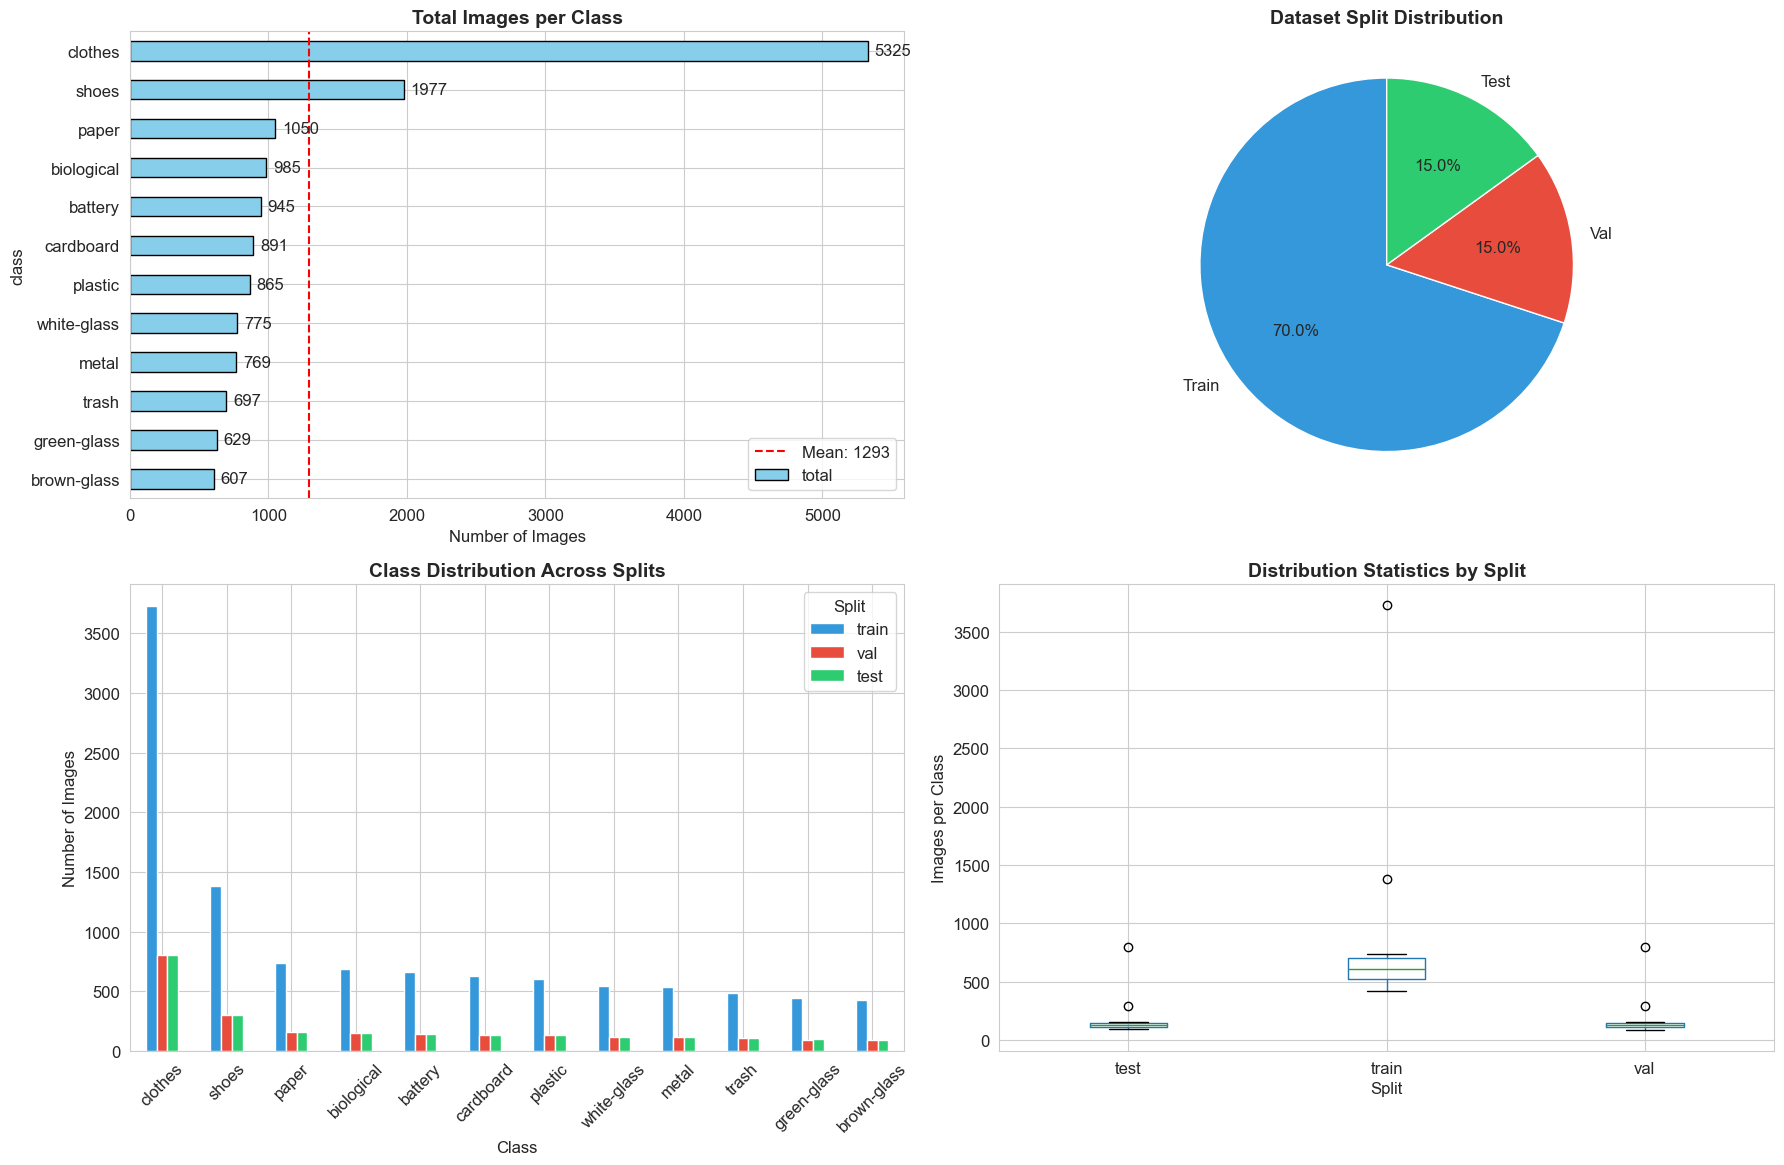

Visualization saved: outputs/eda_class_distribution.png


In [4]:
# Cell 4: Visualization 1 - Overall Distribution

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Bar chart - Total per class
ax1 = axes[0, 0]
df_pivot['total'].sort_values(ascending=True).plot(
    kind='barh', ax=ax1, color='skyblue', edgecolor='black'
)
ax1.set_xlabel('Number of Images')
ax1.set_title('Total Images per Class', fontsize=14, fontweight='bold')
ax1.axvline(df_pivot['total'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_pivot["total"].mean():.0f}')
ax1.legend()

# Add value labels
for i, v in enumerate(df_pivot['total'].sort_values()):
    ax1.text(v + 50, i, str(int(v)), va='center')

# 2. Pie chart - Split distribution
ax2 = axes[0, 1]
split_totals = [
    overview['splits']['train'].values(),
    overview['splits']['val'].values(),
    overview['splits']['test'].values()
]
split_sums = [sum(x) for x in split_totals]
colors = ['#3498db', '#e74c3c', '#2ecc71']

ax2.pie(split_sums, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')

# 3. Stacked bar - Distribution per split
ax3 = axes[1, 0]
df_pivot[['train', 'val', 'test']].plot(
    kind='bar', stacked=False, ax=ax3, color=['#3498db', '#e74c3c', '#2ecc71']
)
ax3.set_xlabel('Class')
ax3.set_ylabel('Number of Images')
ax3.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
ax3.legend(title='Split')
ax3.tick_params(axis='x', rotation=45)

# 4. Box plot - Distribution statistics
ax4 = axes[1, 1]
df_distribution.boxplot(column='count', by='split', ax=ax4)
ax4.set_xlabel('Split')
ax4.set_ylabel('Images per Class')
ax4.set_title('Distribution Statistics by Split', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.savefig('../outputs/eda_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: outputs/eda_class_distribution.png")

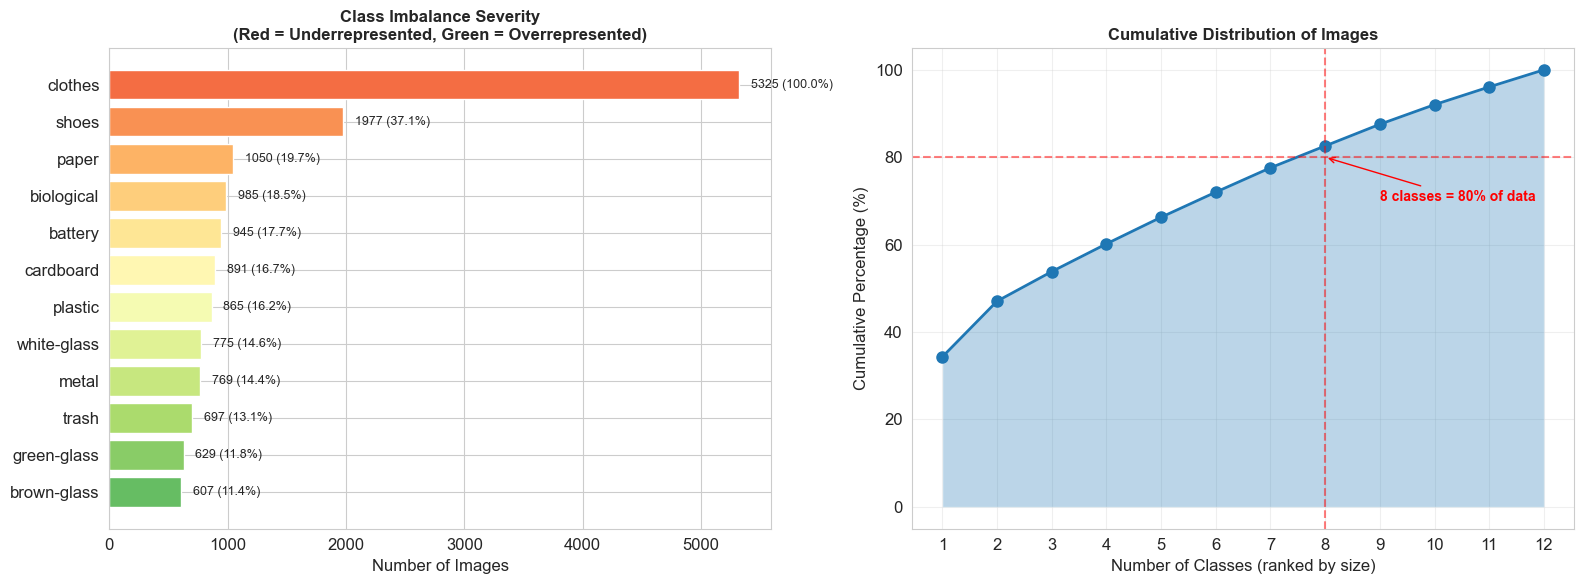

Visualization saved: outputs/eda_imbalance_analysis.png

 INSIGHTS:
• Top 2 classes (clothes, shoes) account for 47.1% of data
• Top 8 classes account for 80% of data (Pareto principle)
• Bottom 3 classes have < 700 images each
• Recommendation: Use class weights or stratified sampling


In [5]:
# Cell 5: Visualization 2 - Imbalance Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Imbalance severity
ax1 = axes[0]
class_totals = df_pivot['total'].sort_values()
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(class_totals)))

bars = ax1.barh(range(len(class_totals)), class_totals, color=colors_gradient)
ax1.set_yticks(range(len(class_totals)))
ax1.set_yticklabels(class_totals.index)
ax1.set_xlabel('Number of Images')
ax1.set_title('Class Imbalance Severity\n(Red = Underrepresented, Green = Overrepresented)', 
              fontsize=12, fontweight='bold')

# Add imbalance ratio annotations
max_count = class_totals.max()
for i, (idx, count) in enumerate(class_totals.items()):
    ratio = count / max_count
    ax1.text(count + 100, i, f'{count} ({ratio:.1%})', va='center', fontsize=9)

# 2. Cumulative distribution
ax2 = axes[1]
sorted_totals = df_pivot['total'].sort_values(ascending=False)
cumsum = sorted_totals.cumsum()
cumsum_pct = cumsum / cumsum.max() * 100

ax2.plot(range(len(sorted_totals)), cumsum_pct, marker='o', linewidth=2, markersize=8)
ax2.fill_between(range(len(sorted_totals)), cumsum_pct, alpha=0.3)
ax2.set_xlabel('Number of Classes (ranked by size)')
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.set_title('Cumulative Distribution of Images', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(len(sorted_totals)))
ax2.set_xticklabels(range(1, len(sorted_totals)+1))

# Annotate 80/20 rule
idx_80 = np.where(cumsum_pct >= 80)[0][0]
ax2.axhline(80, color='red', linestyle='--', alpha=0.5)
ax2.axvline(idx_80, color='red', linestyle='--', alpha=0.5)
ax2.annotate(f'{idx_80+1} classes = 80% of data', 
             xy=(idx_80, 80), xytext=(idx_80+1, 70),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/eda_imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: outputs/eda_imbalance_analysis.png")

# Print insights
print("\n INSIGHTS:")
print(f"• Top 2 classes (clothes, shoes) account for {(sorted_totals[:2].sum() / sorted_totals.sum() * 100):.1f}% of data")
print(f"• Top {idx_80+1} classes account for 80% of data (Pareto principle)")
print(f"• Bottom 3 classes have < 700 images each")
print(f"• Recommendation: Use class weights or stratified sampling")

In [6]:
# Cell 6: Analyze Image Properties

def analyze_image_properties(data_dir, sample_size=100):
    """
    Analyze image dimensions, aspect ratios, file sizes
    """
    
    properties = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'file_sizes': [],
        'channels': [],
        'formats': []
    }
    
    train_dir = data_dir / 'train'
    
    print("🔍 Analyzing image properties...")
    print(f"Sampling {sample_size} images per class...\n")
    
    for class_dir in train_dir.iterdir():
        if not class_dir.is_dir():
            continue
        
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Sample
        sample = np.random.choice(images, min(sample_size, len(images)), replace=False)
        
        for img_path in sample:
            try:
                # Read with PIL for metadata
                with Image.open(img_path) as img:
                    width, height = img.size
                    properties['widths'].append(width)
                    properties['heights'].append(height)
                    properties['aspect_ratios'].append(width / height)
                    properties['formats'].append(img.format)
                    
                    # Channels
                    if img.mode == 'RGB':
                        properties['channels'].append(3)
                    elif img.mode == 'L':
                        properties['channels'].append(1)
                    else:
                        properties['channels'].append(len(img.mode))
                
                # File size
                file_size = img_path.stat().st_size / 1024  # KB
                properties['file_sizes'].append(file_size)
                
            except Exception as e:
                print(f"Error reading {img_path.name}: {e}")
    
    return properties

# Analyze
props = analyze_image_properties(DATA_DIR, sample_size=100)

# Convert to arrays
widths = np.array(props['widths'])
heights = np.array(props['heights'])
aspect_ratios = np.array(props['aspect_ratios'])
file_sizes = np.array(props['file_sizes'])

print("IMAGE PROPERTIES STATISTICS")
print("="*70)
print(f"\n DIMENSIONS:")
print(f"  Width  - Min: {widths.min()}, Max: {widths.max()}, Mean: {widths.mean():.0f}, Median: {np.median(widths):.0f}")
print(f"  Height - Min: {heights.min()}, Max: {heights.max()}, Mean: {heights.mean():.0f}, Median: {np.median(heights):.0f}")

print(f"\n ASPECT RATIOS:")
print(f"  Min: {aspect_ratios.min():.2f}, Max: {aspect_ratios.max():.2f}, Mean: {aspect_ratios.mean():.2f}")

print(f"\n FILE SIZES:")
print(f"  Min: {file_sizes.min():.1f} KB, Max: {file_sizes.max():.1f} KB, Mean: {file_sizes.mean():.1f} KB")

print(f"\n FORMATS:")
format_counts = Counter(props['formats'])
for fmt, count in format_counts.most_common():
    print(f"  {fmt}: {count} images ({count/len(props['formats'])*100:.1f}%)")

print(f"\n CHANNELS:")
channel_counts = Counter(props['channels'])
for ch, count in channel_counts.most_common():
    print(f"  {ch} channels: {count} images ({count/len(props['channels'])*100:.1f}%)")


🔍 Analyzing image properties...
Sampling 100 images per class...

IMAGE PROPERTIES STATISTICS

 DIMENSIONS:
  Width  - Min: 114, Max: 790, Mean: 329, Median: 274
  Height - Min: 120, Max: 770, Mean: 287, Median: 225

 ASPECT RATIOS:
  Min: 0.28, Max: 3.48, Mean: 1.19

 FILE SIZES:
  Min: 1.2 KB, Max: 71.1 KB, Mean: 11.3 KB

 FORMATS:
  JPEG: 1195 images (99.6%)
  PNG: 5 images (0.4%)

 CHANNELS:
  3 channels: 1195 images (99.6%)
  1 channels: 5 images (0.4%)


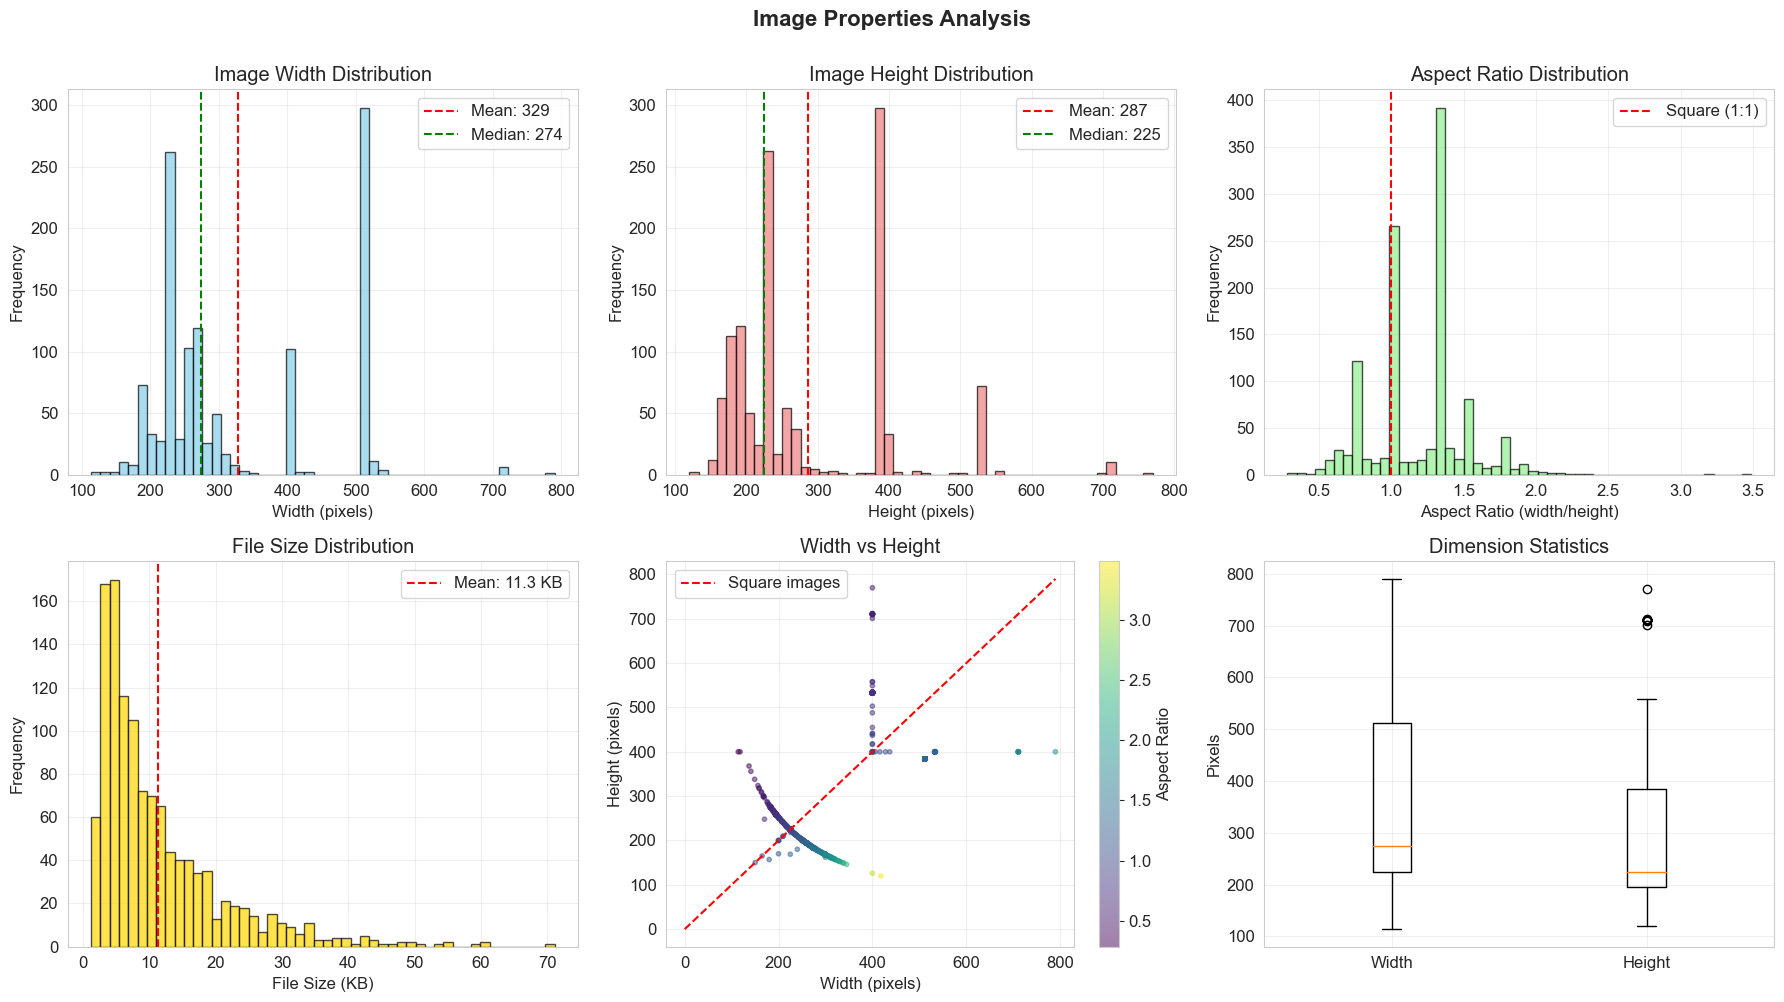

Visualization saved: outputs/eda_image_properties.png


In [7]:
# Cell 7: Visualize Image Properties

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Width distribution
ax1 = axes[0, 0]
ax1.hist(widths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(widths.mean(), color='red', linestyle='--', label=f'Mean: {widths.mean():.0f}')
ax1.axvline(np.median(widths), color='green', linestyle='--', label=f'Median: {np.median(widths):.0f}')
ax1.set_xlabel('Width (pixels)')
ax1.set_ylabel('Frequency')
ax1.set_title('Image Width Distribution')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Height distribution
ax2 = axes[0, 1]
ax2.hist(heights, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.axvline(heights.mean(), color='red', linestyle='--', label=f'Mean: {heights.mean():.0f}')
ax2.axvline(np.median(heights), color='green', linestyle='--', label=f'Median: {np.median(heights):.0f}')
ax2.set_xlabel('Height (pixels)')
ax2.set_ylabel('Frequency')
ax2.set_title('Image Height Distribution')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Aspect ratio distribution
ax3 = axes[0, 2]
ax3.hist(aspect_ratios, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax3.axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
ax3.set_xlabel('Aspect Ratio (width/height)')
ax3.set_ylabel('Frequency')
ax3.set_title('Aspect Ratio Distribution')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. File size distribution
ax4 = axes[1, 0]
ax4.hist(file_sizes, bins=50, color='gold', edgecolor='black', alpha=0.7)
ax4.axvline(file_sizes.mean(), color='red', linestyle='--', label=f'Mean: {file_sizes.mean():.1f} KB')
ax4.set_xlabel('File Size (KB)')
ax4.set_ylabel('Frequency')
ax4.set_title('File Size Distribution')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Scatter: Width vs Height
ax5 = axes[1, 1]
scatter = ax5.scatter(widths, heights, alpha=0.5, c=aspect_ratios, cmap='viridis', s=10)
ax5.plot([0, max(widths.max(), heights.max())], 
         [0, max(widths.max(), heights.max())], 
         'r--', label='Square images')
ax5.set_xlabel('Width (pixels)')
ax5.set_ylabel('Height (pixels)')
ax5.set_title('Width vs Height')
ax5.legend()
ax5.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Aspect Ratio')

# 6. Box plot comparison
ax6 = axes[1, 2]
data_for_box = [widths, heights]
ax6.boxplot(data_for_box, labels=['Width', 'Height'])
ax6.set_ylabel('Pixels')
ax6.set_title('Dimension Statistics')
ax6.grid(alpha=0.3)

plt.suptitle('Image Properties Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../outputs/eda_image_properties.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: outputs/eda_image_properties.png")

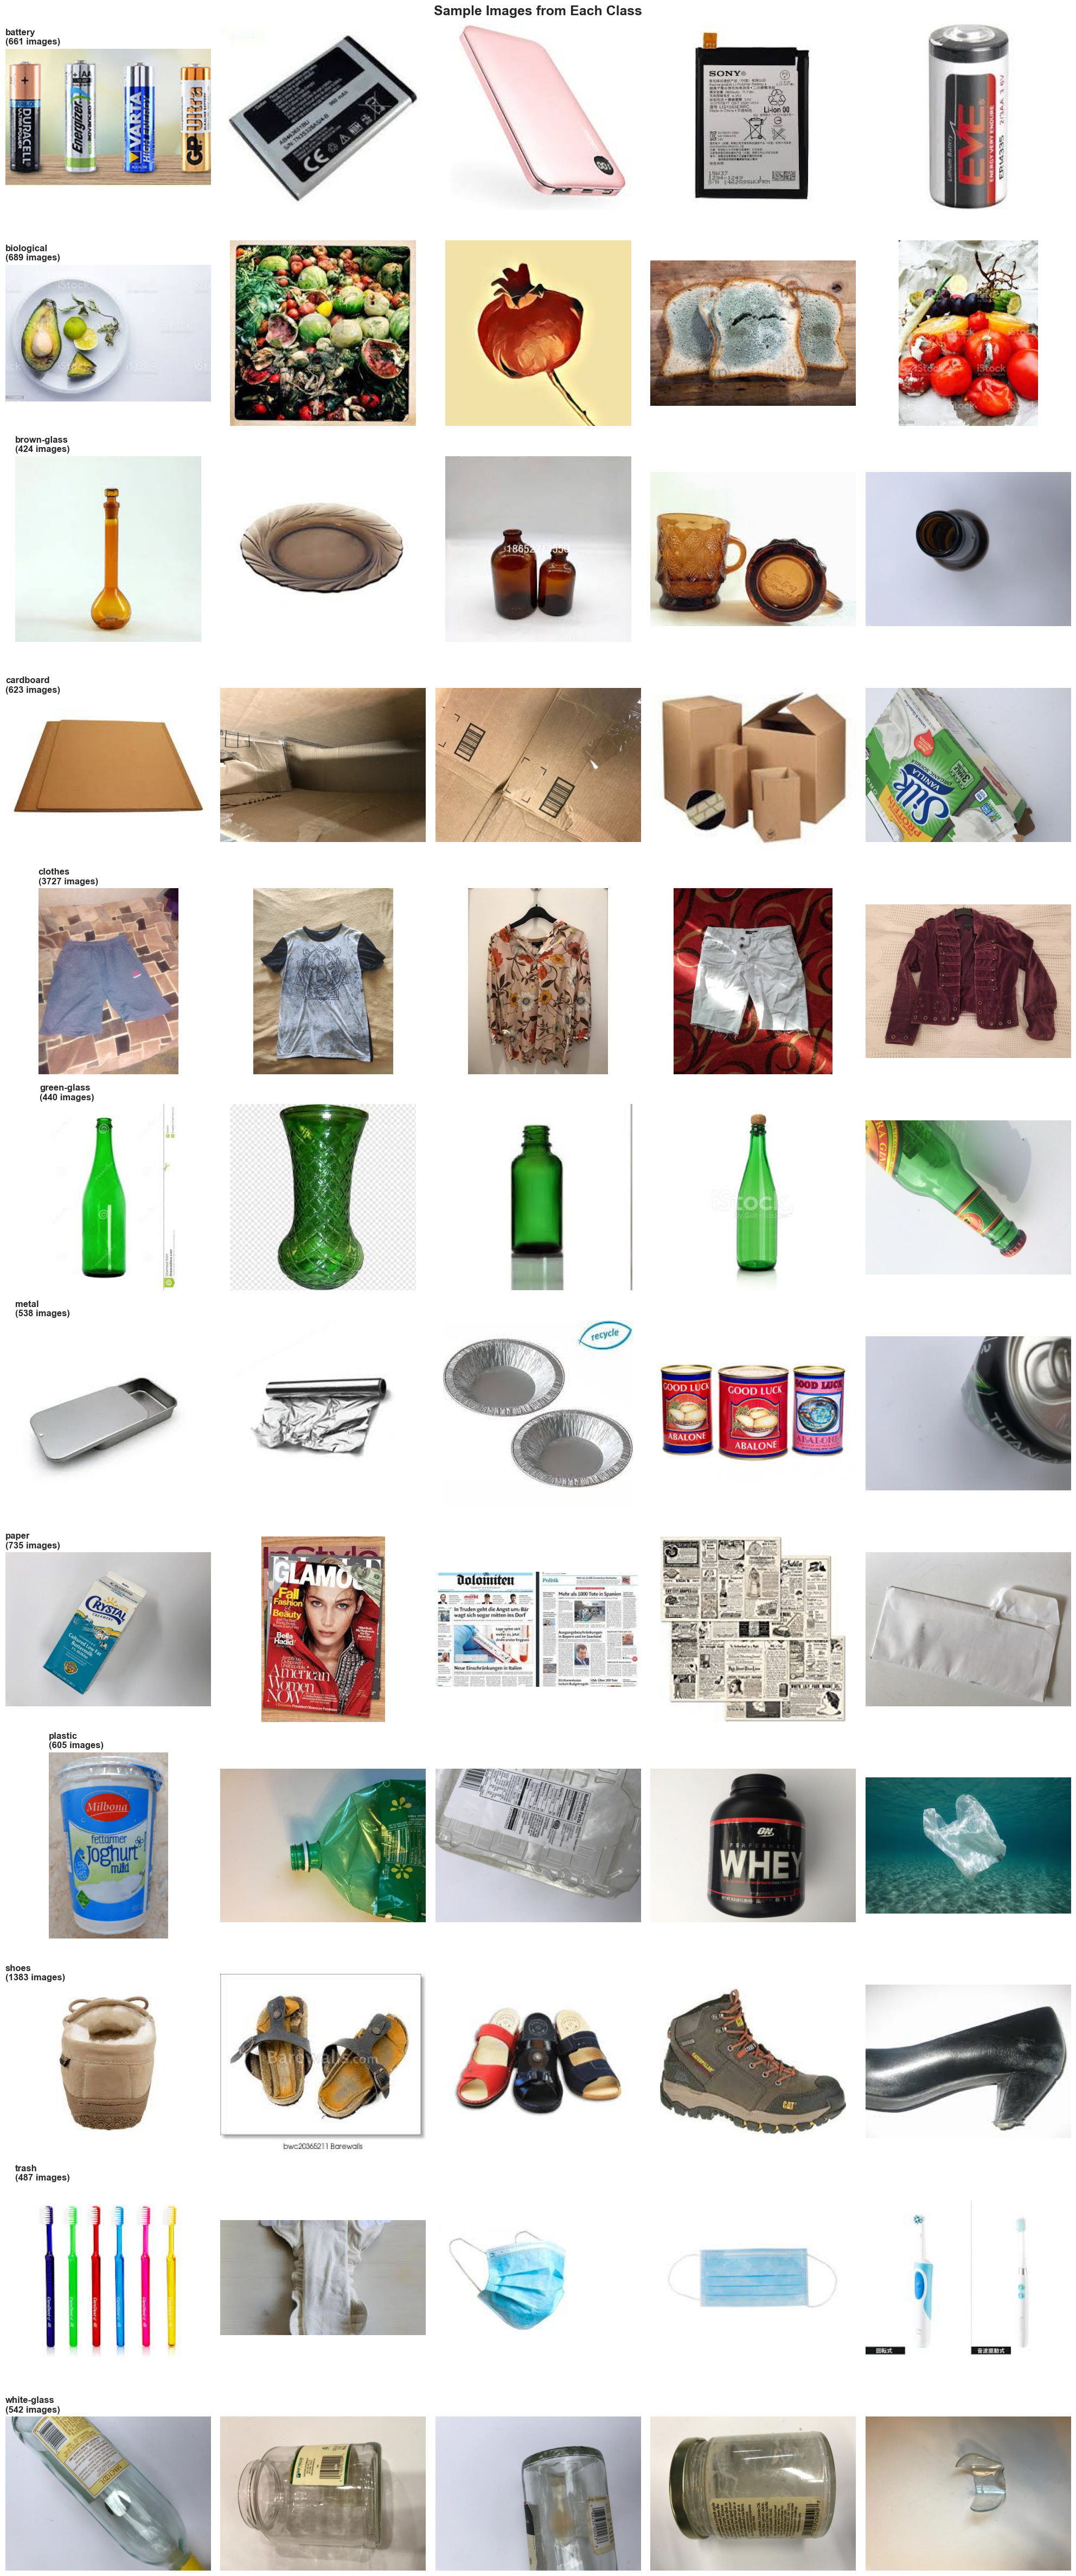

Visualization saved: outputs/eda_sample_images.png


In [8]:
# Cell 8: Visualize Sample Images from Each Class

def plot_sample_images(data_dir, n_samples=5, n_cols=5):
    """
    Plot sample images from each class
    """
    
    train_dir = data_dir / 'train'
    classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    
    n_classes = len(classes)
    n_rows = n_classes
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    
    if n_rows == 1:
        axes = [axes]
    
    for i, class_name in enumerate(classes):
        class_dir = train_dir / class_name
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Random sample
        sample_images = np.random.choice(images, min(n_samples, len(images)), replace=False)
        
        for j, img_path in enumerate(sample_images):
            try:
                img = Image.open(img_path)
                axes[i][j].imshow(img)
                axes[i][j].axis('off')
                
                if j == 0:
                    axes[i][j].set_title(f'{class_name}\n({len(images)} images)', 
                                        fontsize=12, fontweight='bold', loc='left')
            except Exception as e:
                axes[i][j].text(0.5, 0.5, f'Error: {e}', 
                               ha='center', va='center', transform=axes[i][j].transAxes)
                axes[i][j].axis('off')
        
        # Hide unused subplots
        for j in range(len(sample_images), n_cols):
            axes[i][j].axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../outputs/eda_sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved: outputs/eda_sample_images.png")

# Plot samples
plot_sample_images(DATA_DIR, n_samples=5)

In [9]:
# Cell 9: Class Similarity Analysis

import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(" CLASS SIMILARITY ANALYSIS")
print("="*70)

# ============================================================================
# PART 1: VISUAL FEATURE EXTRACTION
# ============================================================================

def extract_color_histogram_features(img_path, bins=32):
    """
    Extract color histogram features from image
    Simple but effective for similarity analysis
    """
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        
        img = cv2.resize(img, (224, 224))
        
        # Extract histogram for each channel
        hist_features = []
        for i in range(3):  # B, G, R
            hist = cv2.calcHist([img], [i], None, [bins], [0, 256])
            hist = hist.flatten()
            hist = hist / (hist.sum() + 1e-7)  # Normalize
            hist_features.extend(hist)
        
        return np.array(hist_features)
    
    except Exception as e:
        return None

def extract_class_features(data_dir, sample_size=50):
    """
    Extract average features for each class
    """
    
    train_dir = data_dir / 'train'
    classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    
    class_features = {}
    
  print(f"\n Extracting features from {len(classes)} classes...")
    print(f"Sample size per class: {sample_size} images\n")
    
    for class_name in tqdm(classes, desc="Processing classes"):
        class_dir = train_dir / class_name
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Sample images
        sample_images = np.random.choice(images, min(sample_size, len(images)), replace=False)
        
        features_list = []
        
        for img_path in sample_images:
            features = extract_color_histogram_features(img_path)
            if features is not None:
                features_list.append(features)
        
        if features_list:
            # Average features for the class
            class_features[class_name] = np.mean(features_list, axis=0)
    
    return class_features, classes

# Extract features
class_features, classes = extract_class_features(DATA_DIR, sample_size=50)

print(f" Feature extraction completed")
print(f"   Feature dimension: {len(list(class_features.values())[0])}")

 CLASS SIMILARITY ANALYSIS

 Extracting features from 12 classes...
Sample size per class: 50 images



Processing classes: 100%|██████████| 12/12 [00:00<00:00, 32.26it/s]

 Feature extraction completed
   Feature dimension: 96


In [10]:
# Cell 10: Compute Similarity Matrix

# Create feature matrix
feature_matrix = np.array([class_features[cls] for cls in classes])

# Compute cosine similarity
similarity_matrix = cosine_similarity(feature_matrix)

print("\n SIMILARITY MATRIX")
print("="*70)
print("\nSimilarity scores (0-1, higher = more similar):\n")

# Create DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=classes,
    columns=classes
)

# Display with formatting
pd.options.display.float_format = '{:.3f}'.format
print(similarity_df)

# Find most similar pairs (excluding diagonal)
print("\n MOST SIMILAR CLASS PAIRS:")
print("="*70)

similar_pairs = []

for i in range(len(classes)):
    for j in range(i+1, len(classes)):
        similarity = similarity_matrix[i, j]
        similar_pairs.append({
            'class1': classes[i],
            'class2': classes[j],
            'similarity': similarity
        })

# Sort by similarity
similar_pairs = sorted(similar_pairs, key=lambda x: x['similarity'], reverse=True)

# Display top 10
for i, pair in enumerate(similar_pairs[:10], 1):
    print(f"{i:2d}. {pair['class1']:15s} ↔ {pair['class2']:15s}  Similarity: {pair['similarity']:.3f}")

# Find least similar pairs
print("\n LEAST SIMILAR CLASS PAIRS:")
print("="*70)

for i, pair in enumerate(similar_pairs[-5:], 1):
    print(f"{i:2d}. {pair['class1']:15s} ↔ {pair['class2']:15s}  Similarity: {pair['similarity']:.3f}")



 SIMILARITY MATRIX

Similarity scores (0-1, higher = more similar):

             battery  biological  brown-glass  cardboard  clothes  \
battery        1.000       0.594        0.936      0.648    0.267   
biological     0.594       1.000        0.770      0.906    0.867   
brown-glass    0.936       0.770        1.000      0.770    0.462   
cardboard      0.648       0.906        0.770      1.000    0.773   
clothes        0.267       0.867        0.462      0.773    1.000   
green-glass    0.861       0.860        0.954      0.863    0.617   
metal          0.847       0.838        0.938      0.892    0.617   
paper          0.408       0.793        0.642      0.816    0.756   
plastic        0.731       0.818        0.874      0.876    0.614   
shoes          0.940       0.812        0.955      0.843    0.557   
trash          0.990       0.540        0.929      0.623    0.192   
white-glass    0.931       0.686        0.970      0.741    0.363   

             green-glass  metal 

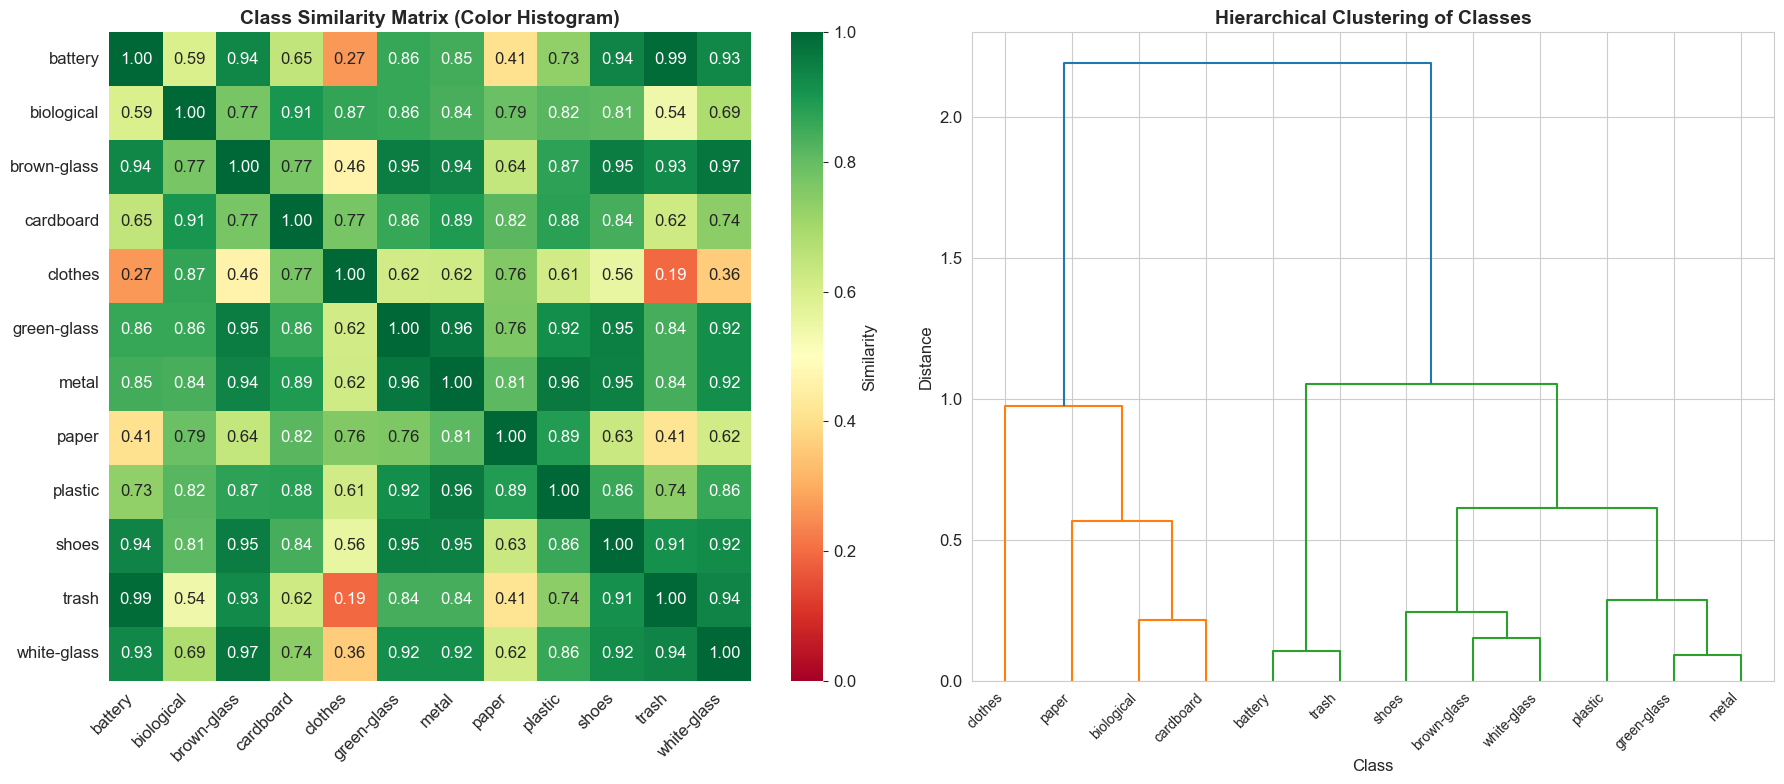

Visualization saved: outputs/eda_similarity_matrix.png


In [11]:
# Cell 11: Visualize Similarity Matrix

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Heatmap
ax1 = axes[0]
sns.heatmap(similarity_df, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax1, cbar_kws={'label': 'Similarity'})
ax1.set_title('Class Similarity Matrix (Color Histogram)', 
              fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# 2. Hierarchical clustering dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

ax2 = axes[1]

# Convert similarity to distance
distance_matrix = 1 - similarity_matrix

# Hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')

# Plot dendrogram
dendrogram(linkage_matrix, labels=classes, ax=ax2, leaf_font_size=10)
ax2.set_title('Hierarchical Clustering of Classes', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Distance')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../outputs/eda_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: outputs/eda_similarity_matrix.png")


 DIMENSIONALITY REDUCTION VISUALIZATION

Applying t-SNE...
Applying PCA...


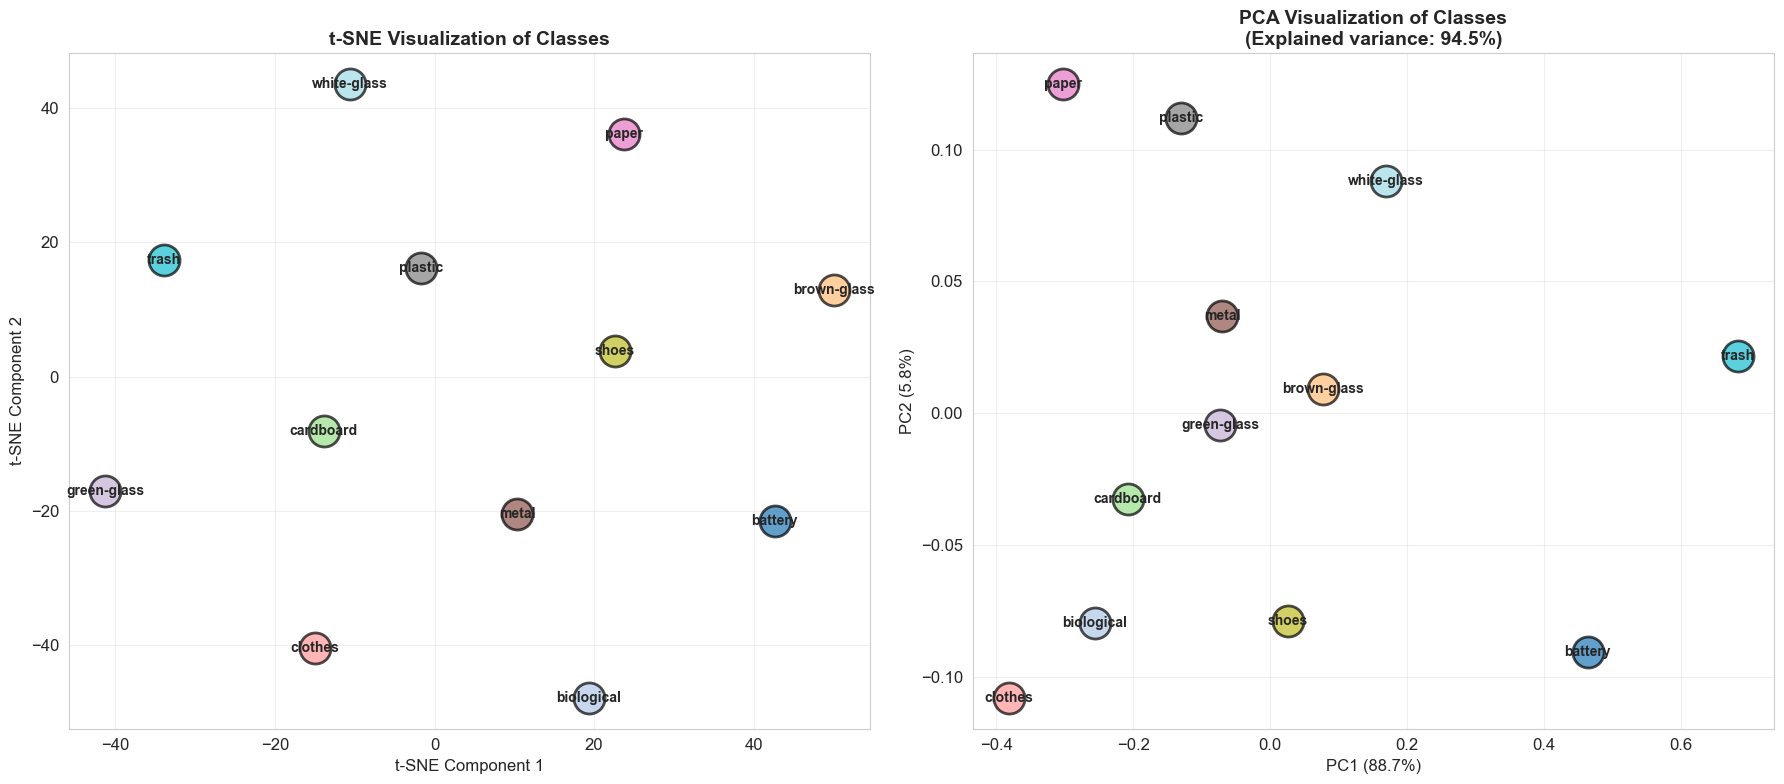


 Visualization saved: outputs/eda_class_clusters.png


In [12]:
# Cell 12: Dimensionality Reduction Visualization (t-SNE)

print("\n DIMENSIONALITY REDUCTION VISUALIZATION")
print("="*70)

# Apply t-SNE
print("\nApplying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(classes)-1))
features_2d = tsne.fit_transform(feature_matrix)

# Apply PCA for comparison
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(feature_matrix)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. t-SNE plot
ax1 = axes[0]

# Color map for classes
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

for i, class_name in enumerate(classes):
    ax1.scatter(features_2d[i, 0], features_2d[i, 1], 
               c=[colors[i]], s=500, alpha=0.7, edgecolors='black', linewidth=2)
    ax1.annotate(class_name, (features_2d[i, 0], features_2d[i, 1]),
                fontsize=10, fontweight='bold', ha='center', va='center')

ax1.set_title('t-SNE Visualization of Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.grid(alpha=0.3)

# 2. PCA plot
ax2 = axes[1]

for i, class_name in enumerate(classes):
    ax2.scatter(features_pca[i, 0], features_pca[i, 1], 
               c=[colors[i]], s=500, alpha=0.7, edgecolors='black', linewidth=2)
    ax2.annotate(class_name, (features_pca[i, 0], features_pca[i, 1]),
                fontsize=10, fontweight='bold', ha='center', va='center')

ax2.set_title(f'PCA Visualization of Classes\n(Explained variance: {pca.explained_variance_ratio_.sum():.1%})', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/eda_class_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved: outputs/eda_class_clusters.png")